# Using R With Quandl Data

We begin by ensuring a few key R packages are loaded

In [12]:
library(MASS)
library(Quandl)
library(ggplot2)
library(stringr)
library(R.cache)

R.cache v0.13.0 (2018-01-03) successfully loaded. See ?R.cache for help.


We are likely to run this notebook over and over, so we add memoizaiton to the data loading function.  This makes testing and re-running our code far faster, and even lets us work offline.

In [5]:
reload.data = TRUE
QLoad <- R.cache::addMemoization(Quandl::Quandl)

### Load the Data

Now we have the code that loads our raw data for Exxon Mobil (XOM) and the Oil futures.

In [9]:
if (reload.data) {
    Quandl.api_key('wFcUAbwJv3FbxzDwExsY')
    cat("Data Reload/n")
    xom.raw <- QLoad(c('WIKI/XOM'))
    oil.raw <- QLoad(c('NSE/OIL'))
    }

Data Reload/n

#### Premium Data

We also subscribe to Quandl's premium data service, which has been professionally assembled

In [11]:
if (reload.data) {
    XSD = QLoad("EOD/HYLS")
    }

In [9]:
head(XSD)

Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
2017-04-07,48.83,48.9300,48.7500,48.79,80683,0,1,48.83,48.9300,48.7500,48.79,80683
2017-04-06,48.89,48.9000,48.8168,48.90,102219,0,1,48.89,48.9000,48.8168,48.90,102219
2017-04-05,48.93,48.9336,48.7900,48.81,154597,0,1,48.93,48.9336,48.7900,48.81,154597
2017-04-04,48.87,48.9115,48.7700,48.86,82315,0,1,48.87,48.9115,48.7700,48.86,82315
2017-04-03,48.89,48.9200,48.7850,48.88,127876,0,1,48.89,48.9200,48.7850,48.88,127876
2017-03-31,48.81,48.8700,48.7900,48.86,442142,0,1,48.81,48.8700,48.7900,48.86,442142


#### Cleanup

Adjust column names so that we can merge the two data sets into a single data frame for analysis

In [4]:
xom <- xom.raw
oil <- oil.raw
names(xom) <- paste("WIKI.XOM -",names(xom))
names(oil) <- paste("NSE.OIL -",names(oil))
names(xom)[1] <-"Date"
names(oil)[1] <-"Date"
raw_data = merge(xom, oil)
names(raw_data)

[1] "Date"                           "WIKI.XOM - Open"               
 [3] "WIKI.XOM - High"                "WIKI.XOM - Low"                
 [5] "WIKI.XOM - Close"               "WIKI.XOM - Volume"             
 [7] "WIKI.XOM - Ex-Dividend"         "WIKI.XOM - Split Ratio"        
 [9] "WIKI.XOM - Adj. Open"           "WIKI.XOM - Adj. High"          
[11] "WIKI.XOM - Adj. Low"            "WIKI.XOM - Adj. Close"         
[13] "WIKI.XOM - Adj. Volume"         "NSE.OIL - Open"                
[15] "NSE.OIL - High"                 "NSE.OIL - Low"                 
[17] "NSE.OIL - Last"                 "NSE.OIL - Close"               
[19] "NSE.OIL - Total Trade Quantity" "NSE.OIL - Turnover (Lacs)"

Peek at the data

In [5]:
head(raw_data)

,Date,WIKI.XOM - Open,WIKI.XOM - High,WIKI.XOM - Low,WIKI.XOM - Close,WIKI.XOM - Volume,WIKI.XOM - Ex-Dividend,WIKI.XOM - Split Ratio,WIKI.XOM - Adj. Open,WIKI.XOM - Adj. High,WIKI.XOM - Adj. Low,WIKI.XOM - Adj. Close,WIKI.XOM - Adj. Volume,NSE.OIL - Open,NSE.OIL - High,NSE.OIL - Low,NSE.OIL - Last,NSE.OIL - Close,NSE.OIL - Total Trade Quantity,NSE.OIL - Turnover (Lacs)
1,2009-09-30,68.98,69.24,68.04,68.61,27117400,0,1,58.55734,58.77806,57.75937,58.24325,27117400,1096,1156.7,1090,1135,1141.2,19748012,223877.1
2,2009-10-01,68.39,68.5,67.09,67.27,24927000,0,1,58.05649,58.14987,56.95291,57.10572,24927000,1102,1173.7,1102,1167,1166.35,3074254,35463.78
3,2009-10-05,66.79,67.78,66.11,67.58,21853000,0,1,56.69824,57.53866,56.12099,57.36888,21853000,1152,1165.9,1136.6,1143,1140.55,919832,10581.13
4,2009-10-06,68.01,69.1,67.78,68.66,21167400,0,1,57.7339,58.65921,57.53866,58.28569,21167400,1149.8,1157.2,1132.1,1143.3,1144.9,627957,7185.9
5,2009-10-07,68.48,68.93,67.96,68.67,15302500,0,1,58.13289,58.5149,57.69146,58.29418,15302500,1153.8,1160.7,1140,1141.45,1141.6,698216,8032.98
6,2009-10-08,68.97,69.3,68.7,69.05,19228800,0,1,58.54885,58.82899,58.31965,58.61676,19228800,1145,1179.8,1142,1178.1,1170.2,788173,9138.99


### Common Quant Task: Massaging The Data

Here we create a function that cleans up column names in our data, for better-looking plot labels and plot specifications

In [6]:
clean.quandl.name <- function(x) {
    cleaned <- x
    if (x=='Date') {
        
    } else {
        tryCatch({
                    parts <- stringr::str_split(x, " - ",n=2)
                    first.parts <- stringr::str_split(parts[[1]][[1]], "\\.",n=2)
                    cleaned <- paste(first.parts[[1]][[2]], parts[[1]][[2]], sep=".")
                    cleaned <- str_replace_all(cleaned," ","")
                    },
                 error = function(e) {cat(paste0("Err on",x,"\n"))}
                 )
    }
    stringr::str_trim(cleaned)
}

Now we can use the _clean.quandl.name_ function to make a better set of column names

In [7]:
fixed.names <- lapply(names(raw_data),clean.quandl.name)
cat(paste(fixed.names,sep="\n"))
renamed_data <- raw_data
names(renamed_data) <- fixed.names

Date XOM.Open XOM.High XOM.Low XOM.Close XOM.Volume XOM.Ex-Dividend XOM.SplitRatio XOM.Adj.Open XOM.Adj.High XOM.Adj.Low XOM.Adj.Close XOM.Adj.Volume OIL.Open OIL.High OIL.Low OIL.Last OIL.Close OIL.TotalTradeQuantity OIL.Turnover(Lacs)

In [8]:
head(renamed_data,5)

,Date,XOM.Open,XOM.High,XOM.Low,XOM.Close,XOM.Volume,XOM.Ex-Dividend,XOM.SplitRatio,XOM.Adj.Open,XOM.Adj.High,XOM.Adj.Low,XOM.Adj.Close,XOM.Adj.Volume,OIL.Open,OIL.High,OIL.Low,OIL.Last,OIL.Close,OIL.TotalTradeQuantity,OIL.Turnover(Lacs)
1,2009-09-30,68.98,69.24,68.04,68.61,27117400,0,1,58.55734,58.77806,57.75937,58.24325,27117400,1096,1156.7,1090,1135,1141.2,19748012,223877.1
2,2009-10-01,68.39,68.5,67.09,67.27,24927000,0,1,58.05649,58.14987,56.95291,57.10572,24927000,1102,1173.7,1102,1167,1166.35,3074254,35463.78
3,2009-10-05,66.79,67.78,66.11,67.58,21853000,0,1,56.69824,57.53866,56.12099,57.36888,21853000,1152,1165.9,1136.6,1143,1140.55,919832,10581.13
4,2009-10-06,68.01,69.1,67.78,68.66,21167400,0,1,57.7339,58.65921,57.53866,58.28569,21167400,1149.8,1157.2,1132.1,1143.3,1144.9,627957,7185.9
5,2009-10-07,68.48,68.93,67.96,68.67,15302500,0,1,58.13289,58.5149,57.69146,58.29418,15302500,1153.8,1160.7,1140,1141.45,1141.6,698216,8032.98


### Examining The Data

Make a standard linear fit

In [9]:
modl <- lm(XOM.Open~OIL.Open, data=renamed_data)
summary(modl)


Call:
lm(formula = XOM.Open ~ OIL.Open, data = renamed_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-21.2181  -6.2930  -0.0541   6.3049  17.7972 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 97.005559   0.468544  207.04   <2e-16 ***
OIL.Open    -0.017681   0.000525  -33.68   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.196 on 1540 degrees of freedom
Multiple R-squared:  0.4241,	Adjusted R-squared:  0.4238 
F-statistic:  1134 on 1 and 1540 DF,  p-value: < 2.2e-16


#### Our linear fit has a *great* t-statistic.  It must be a superb description of the data!

But isn't it suspicious that the slope is negative rather than positive?  Let's take a closer look

In [10]:
gp <- ggplot(renamed_data, aes(x=OIL.Open, y=XOM.Open))+geom_point()+geom_smooth(method=lm)

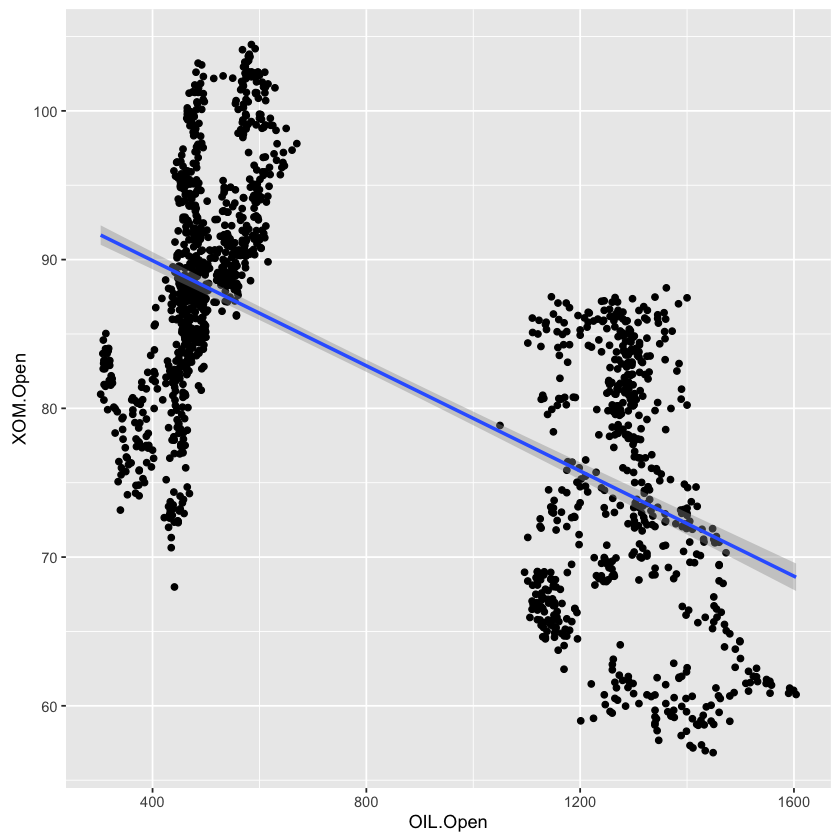

In [11]:
print(gp)